In [2]:
import numpy as np 
import pandas as pd 
from PIL import Image,ImageTk
import os
import cv2
import bs4
import xml.etree.ElementTree as ET
from keras.utils import to_categorical
from kerastuner import RandomSearch
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(300)

/var/folders/tk/mrjkyqms0651_r4m4qvb9xz00000gn/T/ipykernel_8651/405135596.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [8]:
labels_path = 'RSD/annotations'
img_path = 'RSD/images'

In [57]:
ann_path = 'RSD/annotations'
img_path = 'RSD/images'

for ann_file in os.listdir(ann_path):
    tree = ET.parse(os.path.join(ann_path, ann_file))
    root = tree.getroot()
    for obj in root.findall('object'):
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        label = obj.find('name').text
        img_file = ann_file[:-4] + '.png'
        img = cv2.imread(os.path.join(img_path, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        #plt.imshow(img)
        #plt.title(label)
        #plt.show()


In [9]:
#path="RSD/annotations"
content=[]

for filename in os.listdir(labels_path):
    if not filename.endswith('.xml'): continue
    finalpath= os.path.join(labels_path, filename)

    infile = open(finalpath,"r")
    contents = infile.read()
    soup = bs4.BeautifulSoup(contents,'xml')
    class_name=soup.find_all("name")
    name = soup.find_all('filename')
    width= soup.find_all("width")
    height=soup.find_all("height")
    depth=soup.find_all("depth")
    
    ls=[]
    for x in range(0,len(name)):
        for i in name:
            name=name[x].get_text()
            path_name="images/"+name
        class_name=class_name[x].get_text()
        height=int(height[x].get_text())
        depth=int(depth[x].get_text())
        width=int(width[x].get_text())
        f_name=filename
        ls.extend([f_name,path_name,width,height,depth,class_name])

    content.append(ls)

column_names = ["f_name","path_name", "width","height","depth","class_name"]
data = pd.DataFrame(data = content, columns = column_names)
data.class_name=data.class_name.map({'trafficlight':1, 'speedlimit':2, 'crosswalk':3, 'stop':4})
data.head()



,f_name,path_name,width,height,depth,class_name
0,road712.xml,images/road712.png,300,400,3,2
1,road706.xml,images/road706.png,300,400,3,2
2,road289.xml,images/road289.png,300,400,3,4
3,road538.xml,images/road538.png,300,400,3,2
4,road510.xml,images/road510.png,300,400,3,2


In [11]:
data1=[]

for v in data.path_name.values:
    image = Image.open("RSD/"+v).convert("RGB")
    image=image.resize((224,224),Image.ANTIALIAS)
    image=np.array(image.getdata()).reshape(224,224,3)
    data1.append(image)

In [12]:
X=np.array(data1)

y=np.array(data.iloc[:,-1],dtype=int)
c=to_categorical(y,dtype=int)
Y=c[:,1:]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=300)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(701, 224, 224, 3) (176, 224, 224, 3) (701, 4) (176, 4)


In [20]:
data.head()

,f_name,path_name,width,height,depth,class_name
0,road712.xml,images/road712.png,300,400,3,2
1,road706.xml,images/road706.png,300,400,3,2
2,road289.xml,images/road289.png,300,400,3,4
3,road538.xml,images/road538.png,300,400,3,2
4,road510.xml,images/road510.png,300,400,3,2
...,...,...,...,...,...,...
872,road535.xml,images/road535.png,300,400,3,2
873,road284.xml,images/road284.png,300,400,3,2
874,road290.xml,images/road290.png,300,400,3,2
875,road723.xml,images/road723.png,300,400,3,2


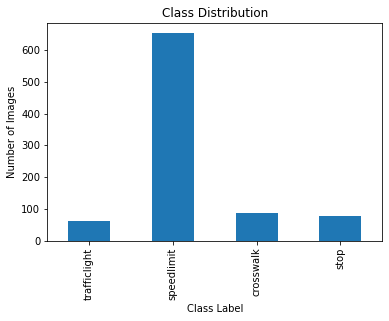

In [28]:
class_counts = data['class_name'].value_counts().sort_index()
class_labels = ['trafficlight', 'speedlimit', 'crosswalk', 'stop']
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.xticks(np.arange(len(class_labels)), class_labels)
plt.show()


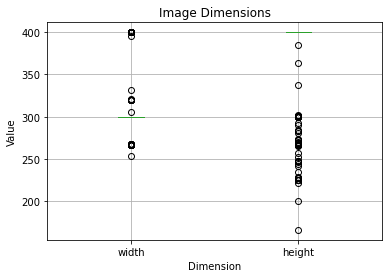

In [29]:
dims = data[['width', 'height']]
dims.boxplot()
plt.title('Image Dimensions')
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.show()


In [30]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(128, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])



In [41]:
from keras.callbacks import ModelCheckpoint
filepath="/Traffic_Sign_Classifier_Project.hdf5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks_list_conv = [cp_callback]

In [43]:
history = model.fit(X_train, y_train, batch_size=64, epochs=4, validation_data=(X_test, y_test))

Epoch 1/4
11/11 [==============================] - 1778s 159s/step - loss: 0.8534 - acc: 0.7461 - val_loss: 0.8806 - val_acc: 0.7330
Epoch 2/4
11/11 [==============================] - 1694s 155s/step - loss: 0.8122 - acc: 0.7461 - val_loss: 0.7845 - val_acc: 0.7330
Epoch 3/4
11/11 [==============================] - 1395s 124s/step - loss: 0.8394 - acc: 0.7575 - val_loss: 0.7839 - val_acc: 0.7614
Epoch 4/4
11/11 [==============================] - 1300s 120s/step - loss: 0.8602 - acc: 0.7432 - val_loss: 0.8090 - val_acc: 0.7386


In [56]:
model.save("model.h5")

In [46]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)


6/6 [==============================] - 74s 12s/step - loss: 0.8090 - acc: 0.7386
Test accuracy: 0.7386363744735718


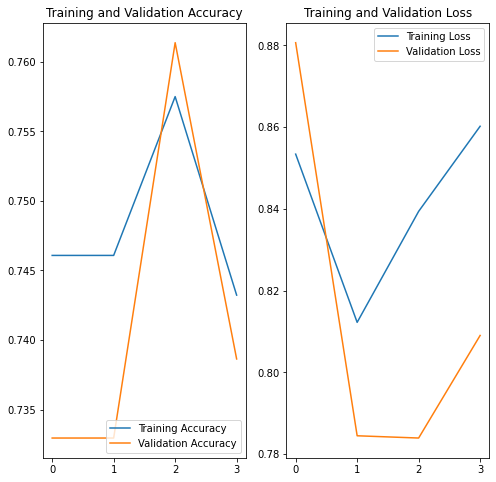

In [49]:
acc = history.history.get('accuracy', history.history.get('acc'))
val_acc = history.history.get('val_accuracy', history.history.get('val_acc'))
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

# Plot accuracy and loss
epochs_range = range(4)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()